Ben Steves, HW7, March 8 2022

## Regression in `scikit-learn`

### Goals

- Practice with the `fit` and `predict` interface of sklearn models
- Get a visual sense of how different regression models work.

### Rationale

Neural nets are strong performers for data that lacks clear features. But for well-structured tabular data with meaningful features (or data that can be translated to that form), simple models can sometimes perform very well, and can be much faster and sometimes more interpretable. Even if you plan to fit a neural net model, training a decision tree or random forest first can be a good quick first pass.

The Scikit-Learn (sklearn) `fit`-`predict` interface for modeling has become the *de facto* industry standard for this sort of modeling, so it's highly likely that what you see here will be useful in your future work.

### Documentation

The sklearn documentation is exemplary. See:

- [Linear Models](https://scikit-learn.org/stable/modules/linear_model.html) for, e.g., linear regression
- [Decision Trees](https://scikit-learn.org/stable/modules/tree.html)
- [Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html) for, e.g., random forests

## Setup

Let's import necessary modules: *pandas* and NumPy for data wrangling, Matplotlib for plotting, and some sklearn models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #plots
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor #decision trees
import sklearn.tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, log_loss, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

We'll load the data. We're using a dataset of home sale prices from the Ames, Iowa assessor's database, described in [this paper](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf). (DATA 202 students may remember seeing this dataset.)

Pandas (typically imported as `pd`, see above) is a very useful library for working with tabular datasets. We'll see here that we can easily read a CSV file directly off the Internet...

In [2]:
ames = pd.read_csv('https://github.com/kcarnold/AmesHousing/blob/master/data/ames.csv.gz?raw=true', compression="gzip")

The main object from pandas is a `DataFrame`. It holds a table of data:

In [3]:
ames.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.638933,42.060899


Each column of data generally has a consistent data type. (Note: `object` columns are the exception. They usually mean "string", but could actually hold any Python object.)

In [4]:
#types and cols
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_SubClass         2930 non-null   object 
 1   MS_Zoning           2930 non-null   object 
 2   Lot_Frontage        2930 non-null   int64  
 3   Lot_Area            2930 non-null   int64  
 4   Street              2930 non-null   object 
 5   Alley               2930 non-null   object 
 6   Lot_Shape           2930 non-null   object 
 7   Land_Contour        2930 non-null   object 
 8   Utilities           2930 non-null   object 
 9   Lot_Config          2930 non-null   object 
 10  Land_Slope          2930 non-null   object 
 11  Neighborhood        2930 non-null   object 
 12  Condition_1         2930 non-null   object 
 13  Condition_2         2930 non-null   object 
 14  Bldg_Type           2930 non-null   object 
 15  House_Style         2930 non-null   object 
 16  Overal

 It behaves like a dictionary of its columns. Each column is a `Series` object.

In [5]:
type(ames['Sale_Price'])

pandas.core.series.Series

`Series` support broadcast operations, similar to NumPy arrays and Torch `tensor`s; they also have other functionality.

In [6]:
#similar to mutate in r
ames['price'] = ames["Sale_Price"] / 100_000 # Make `price` be in units of $100k, to be easier to interpret.

Now we'll look into this dataset:

We'll define some functions to plot the data and models. Since we have latitude and longitude for each home, we can plot this data in 2D with a color for the sale price.

(Sorry, you'll just have to imagine there's a map underneath.)

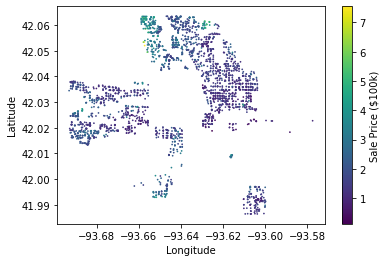

In [7]:
def plot_data():
    # You don't have to know how this function works.
    plt.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=.5) #c is matplot arg for color
    plt.xlabel("Longitude"); plt.ylabel("Latitude") #labels
    plt.colorbar(label="Sale Price ($100k)") #add a colorbar legend
plot_data()

We'll try to predict home price based on *location* (which the realtors assure us is the most important factor anyway). So we'll grab the Latitude and Longitude columns of the data. We'll call that input data `X`, by convention. There are several different ways to index into a pandas `DataFrame`; using a `list` gives us a `DataFrame` with just the columns with those names. We'll then access the underlying NumPy data by using `.values`.

In [8]:
X = ames[['Longitude', 'Latitude']].values #gets the values of two columns (r select essentially)
X.shape #2930 rows and 2 cols

(2930, 2)

Our target, called `y` by convention, will be the home price (we'll soon introduce a different *y*, but start with this one).

In [9]:
y = ames['price'].values #get values for response variable
y.shape

(2930,)

Notice that `X` has two axes and thus is written in uppercase; `y` has 1 and thus is written in lowercase. (This is `sklearn` convention; other libraries are less consistent about this.)

Now let's split the data into a `train` and `valid` set (which sklearn calls train-*test*, but that's fine). `random_state` is how `sklearn` specifies the random seed (it's actually slightly more flexible than a seed).

In [10]:
#train_test_split takes in an x and y and returns 4 sets of data valus as split by the function
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)

We'll verify that the shapes make sense. Note how many items are in each of the sets.

In [11]:
X_train.shape, y_train.shape #80% of values here

((2344, 2), (2344,))

In [12]:
X_valid.shape, y_valid.shape #20% of values here

((586, 2), (586,))

Here's a function to plot our regression model in "data space" (i.e., what it would predict everywhere on the map).

This function is pretty customized to our specific use case, though you can get inspiration from it for use in other situations.

In [13]:
def plot_model(clf, fig=None):
    # Compute extents
    lat_min = ames.Latitude.min()
    lat_max = ames.Latitude.max()
    lon_min = ames.Longitude.min()
    lon_max = ames.Longitude.max()
    price_min = ames.price.min()
    price_max = ames.price.max()

    # Ask the classifier for predictions on a grid
    xx, yy = np.meshgrid(np.linspace(lon_min, lon_max, 250), np.linspace(lat_min, lat_max, 250))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Show the predictions. Superimpose the original data.
    if fig is None:
        plt.figure(figsize=(16, 8))
    plt.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.viridis, vmin=price_min, vmax=price_max)
    plt.scatter(ames['Longitude'], ames['Latitude'], c=ames["price"], s=1, cmap='viridis', vmin=price_min, vmax=price_max)
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.colorbar(label="Sale Price ($100k)")


## Task

### Part A: Linear regression

Step A1: **Fit a linear regression model (call it `linreg`) to the training set (`X_train`, `y_train`).**

In [14]:
linreg = LinearRegression().fit(X_train, y_train)
print("Prediction equation:")
print('y_pred = '
    + ' + ' .join(f'{coef:.3f} * {name}' for coef, name in zip(linreg.coef_, ['Latitude', 'Longitude']))
    + f' + {linreg.intercept_:.3f}')

Prediction equation:
y_pred = -7.955 * Latitude + 11.886 * Longitude + -1242.742


Step A2: **Plot the model's predictions in data space.** The code for step is filled in for you because there's not a generic way to do this; our approach here is customized to our particular model and task so you don't have to understand the details of how it works.

The main thing to observe here is **what shapes do you see**. Think about why you might see those shapes in light of the prediction equation.

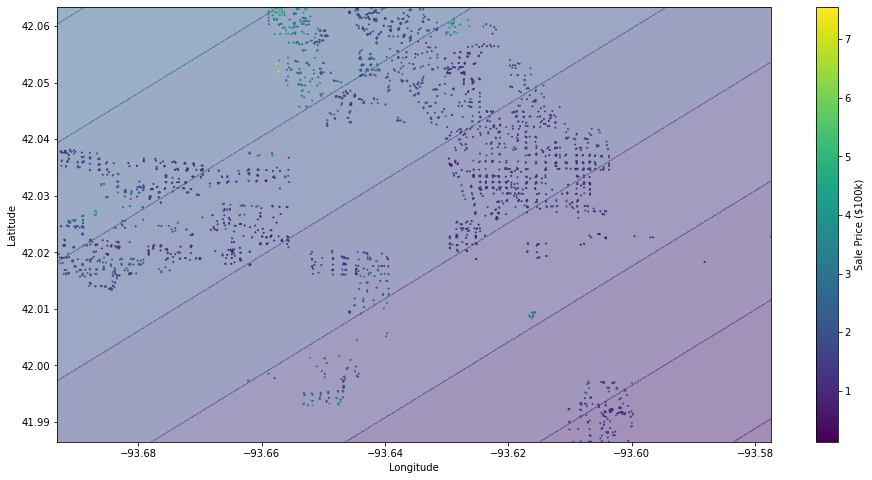

In [15]:
plot_model(linreg)

Step A3: **Compute the model's predictions on the validation set (call them `y_pred`). What does the model predict for the first house in the validation set? How does that compare with the actual price for that home?**

In [16]:
#take our linreg object, which fits training data uses that to predict using test data, 
#which we then compare with actual test data
y_pred = linreg.predict(X_valid)

In [17]:
print("Prediction: %f, Actual: %f, Difference: %f" %(y_pred[0], y_valid[0], abs(y_pred[0]-y_valid[0])))

Prediction: 1.554328, Actual: 1.610000, Difference: 0.055672


Step A4: **Compute and show the mean squared error and the mean absolute error for the validation set.**

- You may use the `mean_absolute_error` and `mean_squared_error` functions (imported from `sklearn.metrics` above).
- Use the predictions you already made above.
- Use Shift-TAB or `?` to get the documentation for these functions to ensure you're passing the arguments in the correct order.

In [18]:
print( "MAE: %f, MSE: %f"  %(mean_absolute_error(y_valid, y_pred), mean_squared_error(y_valid, y_pred)))

MAE: 0.582137, MSE: 0.678657


### Part B: Decision tree regression

Step B1: **Fit a decision tree model (call it `dtree_reg`) to the training set (`X_train`, `y_train`).**

We'll use a small `max_depth` to be able to plot the tree. We'll then fit another one with full depth.

Notice how the tree makes its prediction starting at the top (root) and checking one feature at a time. If the check is `True`, it goes left; otherwise, it goes right. When it hits a node with no check (a "leaf"), it predicts the value stored there. (Think: how do you think it might have computed that value?)

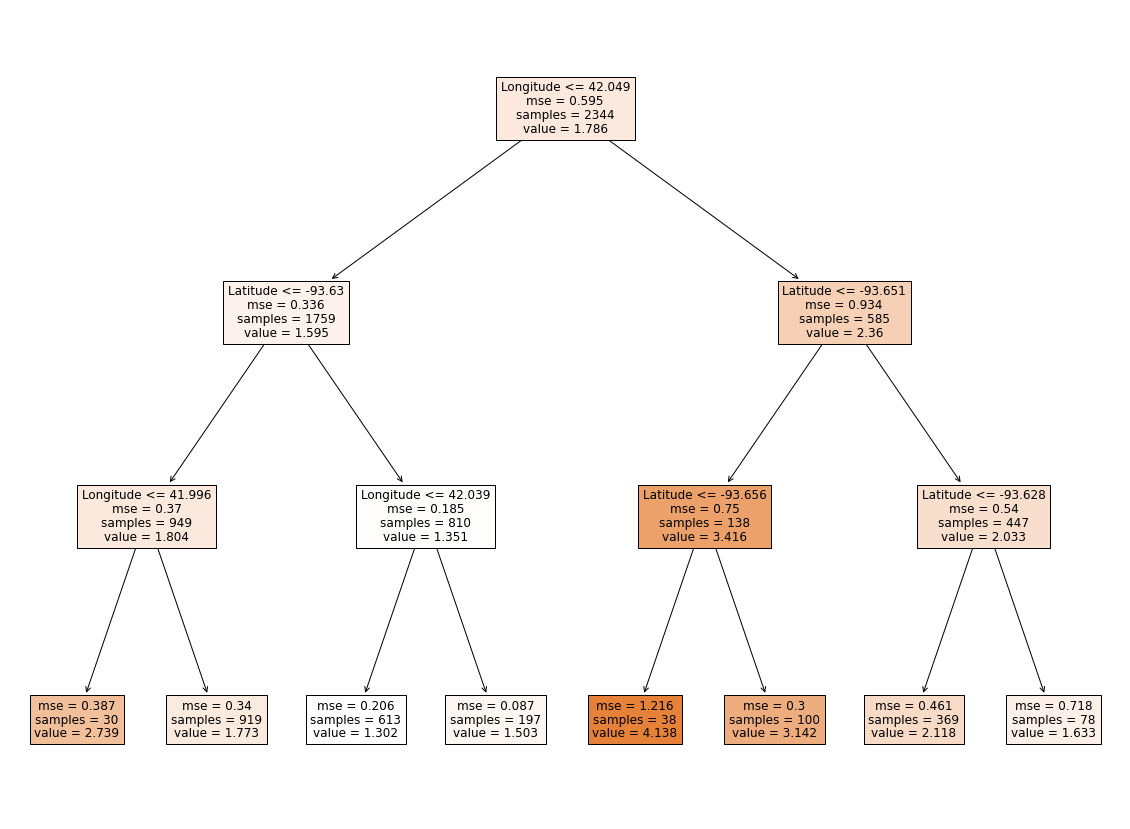

In [19]:
#look at samples to see how many of obs went where. it then seems to predict house price based on which 
#leaf it goes down.
dtree_reg_small = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
plt.figure(figsize=(20, 15))
sklearn.tree.plot_tree(dtree_reg_small, feature_names=["Latitude", "Longitude"], filled=True);

Now let's let the tree grow as big as it wants.

In [20]:
dtree_reg = DecisionTreeRegressor().fit(X_train, y_train)

If the tree is big, the graphic may get unreadable. A text export may be easier to read:

In [21]:
print(sklearn.tree.export_text(dtree_reg, feature_names=["Latitude", "Longitude"], max_depth=2))

|--- Longitude <= 42.05
|   |--- Latitude <= -93.63
|   |   |--- Longitude <= 42.00
|   |   |   |--- truncated branch of depth 9
|   |   |--- Longitude >  42.00
|   |   |   |--- truncated branch of depth 22
|   |--- Latitude >  -93.63
|   |   |--- Longitude <= 42.04
|   |   |   |--- truncated branch of depth 28
|   |   |--- Longitude >  42.04
|   |   |   |--- truncated branch of depth 20
|--- Longitude >  42.05
|   |--- Latitude <= -93.65
|   |   |--- Latitude <= -93.66
|   |   |   |--- truncated branch of depth 12
|   |   |--- Latitude >  -93.66
|   |   |   |--- truncated branch of depth 24
|   |--- Latitude >  -93.65
|   |   |--- Latitude <= -93.63
|   |   |   |--- truncated branch of depth 22
|   |   |--- Latitude >  -93.63
|   |   |   |--- truncated branch of depth 16



Step B2: **Plot the decision tree model in data space**. Observe what shapes of you see.

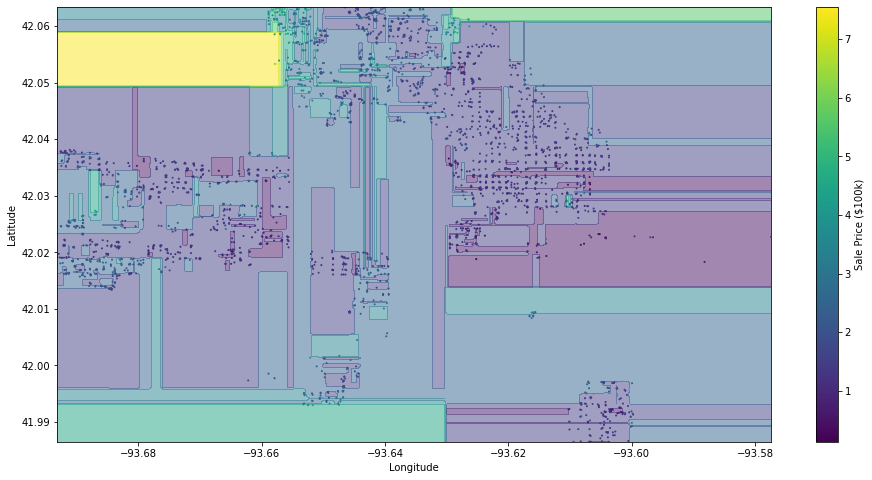

In [22]:
#certain lats and longitudes have different predicted sale price. there are so many spaces with predictions. 
plot_model(dtree_reg)

In [23]:
y_pred_dec = dtree_reg.predict(X_valid)

print( "MAE: %f, MSE: %f"  %(mean_absolute_error(y_valid, y_pred_dec), mean_squared_error(y_valid, y_pred_dec)))

MAE: 0.380162, MSE: 0.398472


### Part C: Random Forest regression

Random Forests take random subsets of the data and fit decision trees to each one. As each tree is fit, it also considers only a random subset of features for each decision. The combination of these two reduces the *variance* of the model, that is, how much the model's predictions change if it's fit on different subsets of data.

**Fit a random forest regression model to this data.** Use the default hyperparameters.

In [24]:
rf_reg = RandomForestRegressor().fit(X_train, y_train)
print(f"We just fit a random forest with {rf_reg.n_estimators} trees.")

We just fit a random forest with 100 trees.


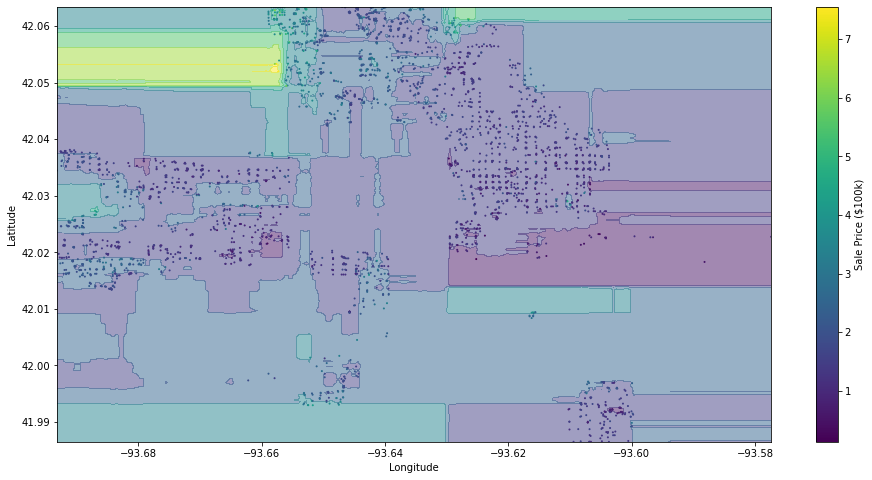

In [25]:
plot_model(rf_reg)

Note: you can use code like this to show all of the different trees in the forest. It may or may not work in your computer, though.

In [26]:
if False:
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    def frame(i):
        plt.clf()
        plot_model(rf_reg.estimators_[i], fig=fig)
        plt.title(f"Tree {i:03d}")
    fig = plt.figure(figsize=(16, 10))
    anim = FuncAnimation(fig=fig, func=frame, frames=len(rf_reg.estimators_))
    # One of these two should work:
    #display(HTML(anim.to_html5_video()))
    display(HTML(anim.to_jshtml()))


Again, compute the predictions and errors.

In [27]:
y_pred_rf = rf_reg.predict(X_valid)

print( "MAE: %f, MSE: %f"  %(mean_absolute_error(y_valid, y_pred_rf), mean_squared_error(y_valid, y_pred_rf)))

MAE: 0.292450, MSE: 0.207088


## Analysis

Q1: Describe the basic steps for fitting a model in sklearn and making predictions.

1. Have some data
2. Create a few initial plots, exploratory analysis, look at variables
3. Choose variables you want to predict (Y) and variables to base those predictions off of to see some relationship (X)
4. Split train and test data (train test split)
5. Fit training data to a model (fit())
6. Make model predictions on the test data (predict())

Q2: Describe parameters that the `fit` method takes. For each one, describe its purpose and its shape.

 `fit` takes the training data for predictor variables (x) and a response variable (y) and creates a model based on that training data. Each parameter has the same number of rows but x can have 1 or more columns and y only contains one.

Q3: Describe, qualitatively, what each of the 3 models here looks like in data space. Describe a characteristic of the visualization that would let you tell immediately which type of model it is from. You might notice differences in the shapes of the boundaries it draws and, if you look more closely, a difference in how the boundaries relate to the data.

Looking the most similar together are the decision tree and random forest models, though the random forest seems to be just a bit more spread out, and while it is still complex in its decisions, it isn't making as many, so it looks a little simpler in comparison to the decision tree visualization. The classification visualization still shows predicted prices at different coordinates, but is not as granular as either decision trees or random forests.

Q4: Describe, quantitatively, how the performance of the different models compares. Which performs best? Which performs worst?

Classification performs the worst (0.58 MAE, 0.68 MSE)

Decision trees is next best (MAE 0.38, MSE 0.40)

Random Forests performs the best (0.29 MAE, 0.20 MSE)

## Extension

*optional*

1. Compute the loss on the *training* set for each of these models. Can that help you tell whether the model overfit or not?
2. Try using more features in the dataset. How well can you predict the price? Be careful about *categorical* features. (Note that you won't be able to use `plot_model` as-is if you add additional features.)